In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
import math
from datetime import date, datetime

In [2]:
data_train = pd.read_csv("KS_train_data.csv", delimiter=",")
data_train.set_index('project_id', inplace=True)
data_test = pd.read_csv("KS_test_data.csv", delimiter=";")
data_test.set_index('project_id', inplace=True)
list(data_train.head(0))

['backers_count',
 'blurb',
 'category',
 'converted_pledged_amount',
 'country',
 'created_at',
 'currency',
 'deadline',
 'fx_rate',
 'goal',
 'launched_at',
 'name',
 'pledged',
 'staff_pick',
 'usd_pledged',
 'location',
 'funded',
 'subcategory',
 'project_url',
 'reward_url']

    backers_count: numbers of persons who have contributed monetary to the project
    blurb: short description of the project underneath the project title
    category: each project is classified in a primary category - art, comics, crafts, dance, design, fashion,        film & video, food, games, journalism, music, photography, publishing, technology, theater
    converted_pledged_amount: amount monetary that was donated in total to the project
    country: 2 letter identifier e.g. UK of the country dated in location - restricts search to the country and                                 then cities are displayed as recommendations
    created_at: UNIX date 
    currency: monetary currency which the project accepts for payments and provides information about                        e.g. rewards brackets 
    deadline: UNIX standard time convertor - last day date of the funding period https://www.epochconverter.com/
    fx_rate: rate of conversion from one currency to USD
    goal: monetary value needed to be donated for the kickstarter project to be be a success
    launched_at: UNIX day date of the first day in the funding period - after project approval
    name: project name - product name or short description of goal
    pledged: total money value raised
    staff_pick: boolean value if staff selected a project -  get prime placement on the website, be promoted to     Kickstarter's 2 million followers on Facebook and Twitter, or appear in Kickstarter's "Projects We Love"                     email, which reaches more than 4 million inboxes every week.  
    usd_pledged: pledged value converted into USD dollars
    location: city, country/state for US - explore category shows projects which are in a specific geolocational part of the world. Posibillity of searching for a project in any city of the world as a filter.
    funded: boolean value whether the project goal has been met through funding 
    subcategory: can be categorised as the category or be in a specific subfield of the primary category
    project_url: website url of the project page 
    reward_url: website url of rewards page - there exist tiers that backers which donate a specific amount         of money will receive

In [11]:
list(data_test.head(0))

['blurb',
 'category',
 'country',
 'created_at',
 'currency',
 'deadline',
 'fx_rate',
 'goal',
 'launched_at',
 'name',
 'staff_pick',
 'location',
 'subcategory',
 'project_url',
 'reward_url']

Data Cleaning

In [3]:
data_train.isnull().any()
data_train['blurb'].isna().sum() #2
data_train['name'].isna().sum() #1
pd.isnull(data_train).any(1).nonzero()[0] #array([ 1857,  5423, 27780, 46838, 56883])
#The null values are NaN in the website data and thus cannot be inserted in the dataframe
data_train['fx_rate'].value_counts()
data_train['currency'].value_counts()
#the goal is not in USD 

USD    80542
GBP     8240
EUR     3823
CAD     3479
AUD     1866
SEK      451
MXN      367
NZD      353
DKK      307
NOK      182
CHF      164
HKD      111
SGD      102
JPY       13
Name: currency, dtype: int64

In [3]:
#transform goal to USD currency:
goal_usd = []
for i in range(len(data_train)):
    value = math.ceil(data_train.iloc[i].fx_rate * data_train.iloc[i].goal)
    goal_usd.append(value)
data_train['goal'] = goal_usd

Feature Selection and Calculation

In [60]:
#feature: upper_case
upper_case = []
for i in range(len(data_train)):
    if data_train.iloc[i].blurb != data_train.iloc[i].blurb:
        upper_case.append(0) 
    else:
        value = sum(map(str.isupper, data_train.iloc[i].blurb.split()))
        upper_case.append(value)
data_train['upper_case'] = upper_case

0     58501
1     29448
2      7672
3      2255
4       853
5       418
6       231
7       119
8        88
9        65
10       50
11       37
17       25
12       25
22       24
13       23
19       19
15       17
14       17
21       16
20       15
23       15
16       14
18       14
24       13
26        9
25        7
27        5
29        2
30        2
28        1
Name: upper_case, dtype: int64

In [70]:
#count number of sentence signs: cor with funded #0.09027529333321695
count_mark = []
data_train['blurb'] = data_train['blurb'].astype(str)
for i in range(len(data_train)):
    val_1 = data_train.iloc[i].blurb.count('!')
    val_2 = data_train.iloc[i].blurb.count('?')
    val_3 = data_train.iloc[i].blurb.count('-')
    val_4 = data_train.iloc[i].blurb.count('$')
    val_5 = data_train.iloc[i].blurb.count(',')
    val_6 = data_train.iloc[i].blurb.count('\'')
    val_7 = data_train.iloc[i].blurb.count('"')
    count_mark.append(val_1+val_2+val_3+val_4+val_5+val_6+val_7)
data_train['count_sign'] = count_mark

In [5]:
#blurb_length: cor with funded: #0.032002518832337956
data_train['blurb'].astype(str)
blurb_length = []
for i in range(len(data_train)):
    if data_train.iloc[i].blurb != data_train.iloc[i].blurb:
        blurb_length.append(0)
    else:
        blurb_length.append(len(data_train.iloc[i].blurb))  
data_train['blurb_length'] = blurb_length

In [6]:
#period_lc
#period_dl
#money_pday
launched_at = []
created_at = []
deadline = []
for i in range(len(data_train)):
    launched_at.append(datetime.utcfromtimestamp(data_train.iloc[i].launched_at).strftime('%Y-%m-%d'))
    created_at.append(datetime.utcfromtimestamp(data_train.iloc[i].created_at).strftime('%Y-%m-%d'))
    deadline.append(datetime.utcfromtimestamp(data_train.iloc[i].deadline).strftime('%Y-%m-%d'))

date_format = "%Y-%m-%d"
period_lc = []
period_dl = []
money_pday = []
for i in range(len(data_train)):
    l = launched_at[i]
    l = datetime.strptime(l, date_format)
    c = created_at[i]
    c = datetime.strptime(c, date_format)
    d = deadline[i]
    d = datetime.strptime(d, date_format)
    lc = l - c
    period_lc.append(lc.days)
    dl = d - l
    period_dl.append(dl.days)
    money_pday.append(math.ceil(data_train.iloc[i].goal / dl.days)) 
data_train['period_lc'] = period_lc
data_train['period_dl'] = period_dl
data_train['money_pday'] = money_pday

In [7]:
#name_length: #0.12593483192454363
data_train['name_length'] = data_train['name']
name_length = []
for i in range(len(data_train)):
    if data_train.iloc[i].name_length != data_train.iloc[i].name_length:
        name_length.append(0)
    else:
        name_length.append(len(data_train.iloc[i].name_length))   
data_train['name_length'] = name_length

In [8]:
#competitors_qtr
#competitors_month
def get_year(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    return time_s.year
data_train['launched_year'] = data_train['launched_at'].apply(get_year)

def get_month(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    return time_s.month
data_train['launched_month'] = data_train['launched_at'].apply(get_month)

def get_week(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    return time_s.isocalendar()[1]
data_train['launched_week'] = data_train['launched_at'].apply(get_week)

def get_quarter(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    if (time_s.month > 0 and time_s.month < 4):
        return 1
    if (time_s.month > 3 and time_s.month < 7):
        return 2
    if (time_s.month > 6 and time_s.month < 10):
        return 3
    if (time_s.month > 9 and time_s.month < 13):
        return 4
data_train['launched_quarter'] = data_train['launched_at'].apply(get_quarter)

data_train['goal_cat_perc'] =  data_train.groupby(['category'])['goal'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =[1,2,3]))
data_train['duration_cat_perc'] =  data_train.groupby(['category'])['period_dl'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =False, duplicates='drop'))

data_train['competitors_qtr'] = data_train.groupby(['category','launched_year','launched_quarter','goal_cat_perc'])['funded'].transform('count')
data_train['competitors_month'] = data_train.groupby(['category','launched_year','launched_month','goal_cat_perc'])['funded'].transform('count')

In [9]:
#category_art #category_comics #category_crafts #category_dance #category_design #category_fashion                                                            
#category_film & video #category_food #category_games #category_journalism #category_music                                                              
#category_photography #category_publishing #category_technology #category_theater    
data_train = pd.get_dummies(data_train, columns = ['category'])

Data Transformation for Model

In [10]:
#standardize: staff_pick
boolean_v = []
for i in range(len(data_train)):
    boolean = data_train.iloc[i].staff_pick
    if boolean == True:
        boolean_v.append(1)
    elif boolean == False:
        boolean_v.append(0)
data_train['staff_pick'] = boolean_v

In [11]:
#standardize: funded
boolean_v = []
for i in range(len(data_train)):
    boolean = data_train.iloc[i].funded
    if boolean == True:
        boolean_v.append(1)
    elif boolean == False:
        boolean_v.append(0)
data_train['funded'] = boolean_v

In [71]:
data_f = data_train[['goal','staff_pick', 'blurb_length', 'period_lc', 'period_dl', 'money_pday', 'name_length', 'competitors_qtr', 'competitors_month', 'category_art', 'category_comics', 'category_crafts', 'category_dance', 'category_design', 'category_fashion', 'category_film & video', 'category_food', 'category_games', 'category_journalism', 'category_music', 'category_photography', 'category_publishing', 'category_technology', 'category_theater', 'upper_case', 'count_sign', 'funded']]

In [ ]:
#data_f = data_train[['goal', 'staff_pick', 'blurb_length', 'period_lc', 'period_dl', 'money_pday', 'name_length', 'competitors_qtr', 'competitors_month', 'category_art', 'category_comics', 'category_crafts', 'category_dance', 'category_design', 'category_fashion', 'category_film & video', 'category_food', 'category_games', 'category_journalism', 'category_music', 'category_photography', 'category_publishing', 'category_technology', 'category_theater', 'funded']]

In [72]:
#standardize: MinMax
data_fminmax = data_f
dataset_mm = data_fminmax.values
X = dataset_mm[:,0:26]
Y_mm = dataset_mm[:,26]
scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler.fit(scaler, X)
X_mm = scaler.transform(X)

In [73]:
X_train_mm, X_val_and_test_mm, Y_train_mm, Y_val_and_test_mm = train_test_split(X_mm, Y_mm, test_size=0.3)

Create Model

In [15]:
from keras import backend as K
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.utils import plot_model

Using TensorFlow backend.


In [16]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#K-fold validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X_train_mm, Y_train_mm):
  # create model
    input_l = Input(shape=(26,))
    hidden1 = Dense(13, activation='relu')(input_l)
    output_l = Dense(1, activation='sigmoid')(hidden1)
    model = Model(inputs=input_l, outputs=output_l)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
    model.fit(X_train_mm, Y_train_mm, batch_size=32, epochs=200, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_val_and_test_mm, Y_val_and_test_mm, verbose=0)
    print(model.metrics_names[1:5], scores[1]*100, scores[2]*100, scores[3]*100, scores[4]*100)
    cvscores.append(scores[1] * 100)
    cvscores.append(scores[2] * 100)
    cvscores.append(scores[3] * 100)
    cvscores.append(scores[4] * 100)
#print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

['accuracy', 'f1_m', 'precision_m', 'recall_m'] 73.17000031471252 78.25862169265747 73.101806640625 85.18990278244019
['accuracy', 'f1_m', 'precision_m', 'recall_m'] 72.86999821662903 76.66181325912476 75.61062574386597 78.7363350391388


In [74]:
input_l = Input(shape=(26,))
hidden1 = Dense(13, activation='relu')(input_l)
output_l = Dense(1, activation='sigmoid')(hidden1)
model = Model(inputs=input_l, outputs=output_l)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])

In [79]:
history = model.fit(X_train_mm, Y_train_mm, batch_size=32, epochs=400, verbose = 1, validation_split=0.30)

Train on 49000 samples, validate on 21000 samples
Epoch 1/500
49000/49000 [==============================] - 2s 33us/step - loss: 0.5089 - accuracy: 0.7435 - f1_m: 0.7896 - precision_m: 0.7512 - recall_m: 0.8432 - val_loss: 0.5188 - val_accuracy: 0.7362 - val_f1_m: 0.7823 - val_precision_m: 0.7446 - val_recall_m: 0.8333
Epoch 2/500
49000/49000 [==============================] - 2s 35us/step - loss: 0.5090 - accuracy: 0.7437 - f1_m: 0.7899 - precision_m: 0.7511 - recall_m: 0.8441 - val_loss: 0.5178 - val_accuracy: 0.7358 - val_f1_m: 0.7798 - val_precision_m: 0.7490 - val_recall_m: 0.8226
Epoch 3/500
49000/49000 [==============================] - 2s 33us/step - loss: 0.5094 - accuracy: 0.7432 - f1_m: 0.7893 - precision_m: 0.7514 - recall_m: 0.8422 - val_loss: 0.5206 - val_accuracy: 0.7332 - val_f1_m: 0.7756 - val_precision_m: 0.7504 - val_recall_m: 0.8121
Epoch 4/500
49000/49000 [==============================] - 2s 36us/step - loss: 0.5094 - accuracy: 0.7436 - f1_m: 0.7902 - precision_m

Epoch 31/500
49000/49000 [==============================] - 1s 29us/step - loss: 0.5085 - accuracy: 0.7462 - f1_m: 0.7920 - precision_m: 0.7532 - recall_m: 0.8456 - val_loss: 0.5167 - val_accuracy: 0.7375 - val_f1_m: 0.7851 - val_precision_m: 0.7421 - val_recall_m: 0.8427
Epoch 32/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5090 - accuracy: 0.7438 - f1_m: 0.7898 - precision_m: 0.7507 - recall_m: 0.8447 - val_loss: 0.5210 - val_accuracy: 0.7347 - val_f1_m: 0.7712 - val_precision_m: 0.7645 - val_recall_m: 0.7872
Epoch 33/500
49000/49000 [==============================] - 1s 29us/step - loss: 0.5087 - accuracy: 0.7438 - f1_m: 0.7895 - precision_m: 0.7512 - recall_m: 0.8427 - val_loss: 0.5180 - val_accuracy: 0.7386 - val_f1_m: 0.7886 - val_precision_m: 0.7379 - val_recall_m: 0.8558
Epoch 34/500
49000/49000 [==============================] - 1s 30us/step - loss: 0.5088 - accuracy: 0.7428 - f1_m: 0.7892 - precision_m: 0.7498 - recall_m: 0.8435 - val_loss: 0.5225

49000/49000 [==============================] - 2s 32us/step - loss: 0.5086 - accuracy: 0.7429 - f1_m: 0.7891 - precision_m: 0.7508 - recall_m: 0.8424 - val_loss: 0.5188 - val_accuracy: 0.7368 - val_f1_m: 0.7897 - val_precision_m: 0.7303 - val_recall_m: 0.8687
Epoch 62/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5083 - accuracy: 0.7447 - f1_m: 0.7904 - precision_m: 0.7518 - recall_m: 0.8437 - val_loss: 0.5183 - val_accuracy: 0.7366 - val_f1_m: 0.7784 - val_precision_m: 0.7545 - val_recall_m: 0.8133
Epoch 63/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5082 - accuracy: 0.7450 - f1_m: 0.7906 - precision_m: 0.7525 - recall_m: 0.8435 - val_loss: 0.5176 - val_accuracy: 0.7367 - val_f1_m: 0.7816 - val_precision_m: 0.7468 - val_recall_m: 0.8292
Epoch 64/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5085 - accuracy: 0.7442 - f1_m: 0.7906 - precision_m: 0.7526 - recall_m: 0.8438 - val_loss: 0.5223 - val_accura

49000/49000 [==============================] - 2s 33us/step - loss: 0.5076 - accuracy: 0.7457 - f1_m: 0.7920 - precision_m: 0.7520 - recall_m: 0.8470 - val_loss: 0.5196 - val_accuracy: 0.7354 - val_f1_m: 0.7725 - val_precision_m: 0.7642 - val_recall_m: 0.7908
Epoch 92/500
49000/49000 [==============================] - 2s 36us/step - loss: 0.5084 - accuracy: 0.7443 - f1_m: 0.7899 - precision_m: 0.7536 - recall_m: 0.8415 - val_loss: 0.5190 - val_accuracy: 0.7373 - val_f1_m: 0.7909 - val_precision_m: 0.7302 - val_recall_m: 0.8719
Epoch 93/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5082 - accuracy: 0.7439 - f1_m: 0.7903 - precision_m: 0.7509 - recall_m: 0.8451 - val_loss: 0.5191 - val_accuracy: 0.7366 - val_f1_m: 0.7903 - val_precision_m: 0.7286 - val_recall_m: 0.8725
Epoch 94/500
49000/49000 [==============================] - 2s 34us/step - loss: 0.5083 - accuracy: 0.7452 - f1_m: 0.7919 - precision_m: 0.7530 - recall_m: 0.8458 - val_loss: 0.5185 - val_accura

Epoch 121/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5076 - accuracy: 0.7446 - f1_m: 0.7906 - precision_m: 0.7522 - recall_m: 0.8441 - val_loss: 0.5195 - val_accuracy: 0.7362 - val_f1_m: 0.7770 - val_precision_m: 0.7555 - val_recall_m: 0.8090
Epoch 122/500
49000/49000 [==============================] - 2s 34us/step - loss: 0.5079 - accuracy: 0.7442 - f1_m: 0.7906 - precision_m: 0.7518 - recall_m: 0.8443 - val_loss: 0.5169 - val_accuracy: 0.7385 - val_f1_m: 0.7885 - val_precision_m: 0.7372 - val_recall_m: 0.8564
Epoch 123/500
49000/49000 [==============================] - 2s 34us/step - loss: 0.5079 - accuracy: 0.7456 - f1_m: 0.7915 - precision_m: 0.7534 - recall_m: 0.8445 - val_loss: 0.5178 - val_accuracy: 0.7365 - val_f1_m: 0.7892 - val_precision_m: 0.7310 - val_recall_m: 0.8667
Epoch 124/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5078 - accuracy: 0.7450 - f1_m: 0.7908 - precision_m: 0.7520 - recall_m: 0.8451 - val_loss: 0.

Epoch 151/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5075 - accuracy: 0.7457 - f1_m: 0.7917 - precision_m: 0.7530 - recall_m: 0.8449 - val_loss: 0.5182 - val_accuracy: 0.7381 - val_f1_m: 0.7810 - val_precision_m: 0.7523 - val_recall_m: 0.8213
Epoch 152/500
49000/49000 [==============================] - 2s 36us/step - loss: 0.5076 - accuracy: 0.7431 - f1_m: 0.7892 - precision_m: 0.7509 - recall_m: 0.8424 - val_loss: 0.5185 - val_accuracy: 0.7368 - val_f1_m: 0.7814 - val_precision_m: 0.7489 - val_recall_m: 0.8263
Epoch 153/500
49000/49000 [==============================] - 2s 36us/step - loss: 0.5074 - accuracy: 0.7451 - f1_m: 0.7914 - precision_m: 0.7527 - recall_m: 0.8449 - val_loss: 0.5167 - val_accuracy: 0.7359 - val_f1_m: 0.7842 - val_precision_m: 0.7400 - val_recall_m: 0.8434
Epoch 154/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5078 - accuracy: 0.7454 - f1_m: 0.7907 - precision_m: 0.7537 - recall_m: 0.8431 - val_loss: 0.

Epoch 181/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5079 - accuracy: 0.7452 - f1_m: 0.7910 - precision_m: 0.7533 - recall_m: 0.8433 - val_loss: 0.5184 - val_accuracy: 0.7392 - val_f1_m: 0.7902 - val_precision_m: 0.7364 - val_recall_m: 0.8618
Epoch 182/500
49000/49000 [==============================] - 2s 35us/step - loss: 0.5076 - accuracy: 0.7441 - f1_m: 0.7900 - precision_m: 0.7524 - recall_m: 0.8426 - val_loss: 0.5192 - val_accuracy: 0.7377 - val_f1_m: 0.7847 - val_precision_m: 0.7431 - val_recall_m: 0.8399
Epoch 183/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5077 - accuracy: 0.7432 - f1_m: 0.7890 - precision_m: 0.7509 - recall_m: 0.8421 - val_loss: 0.5237 - val_accuracy: 0.7338 - val_f1_m: 0.7701 - val_precision_m: 0.7652 - val_recall_m: 0.7847
Epoch 184/500
49000/49000 [==============================] - 2s 33us/step - loss: 0.5078 - accuracy: 0.7452 - f1_m: 0.7909 - precision_m: 0.7531 - recall_m: 0.8437 - val_loss: 0.

Epoch 211/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5074 - accuracy: 0.7459 - f1_m: 0.7917 - precision_m: 0.7531 - recall_m: 0.8450 - val_loss: 0.5183 - val_accuracy: 0.7376 - val_f1_m: 0.7886 - val_precision_m: 0.7347 - val_recall_m: 0.8599
Epoch 212/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5077 - accuracy: 0.7442 - f1_m: 0.7899 - precision_m: 0.7529 - recall_m: 0.8423 - val_loss: 0.5169 - val_accuracy: 0.7376 - val_f1_m: 0.7819 - val_precision_m: 0.7496 - val_recall_m: 0.8270
Epoch 213/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5072 - accuracy: 0.7444 - f1_m: 0.7897 - precision_m: 0.7524 - recall_m: 0.8417 - val_loss: 0.5195 - val_accuracy: 0.7365 - val_f1_m: 0.7909 - val_precision_m: 0.7277 - val_recall_m: 0.8760
Epoch 214/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5075 - accuracy: 0.7442 - f1_m: 0.7905 - precision_m: 0.7523 - recall_m: 0.8435 - val_loss: 0.

Epoch 241/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5074 - accuracy: 0.7446 - f1_m: 0.7903 - precision_m: 0.7516 - recall_m: 0.8437 - val_loss: 0.5174 - val_accuracy: 0.7386 - val_f1_m: 0.7876 - val_precision_m: 0.7392 - val_recall_m: 0.8518
Epoch 242/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5075 - accuracy: 0.7451 - f1_m: 0.7905 - precision_m: 0.7528 - recall_m: 0.8432 - val_loss: 0.5188 - val_accuracy: 0.7369 - val_f1_m: 0.7886 - val_precision_m: 0.7337 - val_recall_m: 0.8619
Epoch 243/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5077 - accuracy: 0.7458 - f1_m: 0.7919 - precision_m: 0.7536 - recall_m: 0.8450 - val_loss: 0.5165 - val_accuracy: 0.7399 - val_f1_m: 0.7842 - val_precision_m: 0.7505 - val_recall_m: 0.8306
Epoch 244/500
49000/49000 [==============================] - 2s 33us/step - loss: 0.5080 - accuracy: 0.7436 - f1_m: 0.7893 - precision_m: 0.7523 - recall_m: 0.8413 - val_loss: 0.

Epoch 271/500
49000/49000 [==============================] - 2s 33us/step - loss: 0.5078 - accuracy: 0.7444 - f1_m: 0.7900 - precision_m: 0.7524 - recall_m: 0.8424 - val_loss: 0.5178 - val_accuracy: 0.7368 - val_f1_m: 0.7818 - val_precision_m: 0.7482 - val_recall_m: 0.8280
Epoch 272/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5076 - accuracy: 0.7450 - f1_m: 0.7898 - precision_m: 0.7515 - recall_m: 0.8428 - val_loss: 0.5178 - val_accuracy: 0.7360 - val_f1_m: 0.7853 - val_precision_m: 0.7373 - val_recall_m: 0.8496
Epoch 273/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5076 - accuracy: 0.7429 - f1_m: 0.7889 - precision_m: 0.7520 - recall_m: 0.8406 - val_loss: 0.5189 - val_accuracy: 0.7349 - val_f1_m: 0.7844 - val_precision_m: 0.7365 - val_recall_m: 0.8485
Epoch 274/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5069 - accuracy: 0.7458 - f1_m: 0.7917 - precision_m: 0.7547 - recall_m: 0.8437 - val_loss: 0.

Epoch 301/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5070 - accuracy: 0.7460 - f1_m: 0.7921 - precision_m: 0.7532 - recall_m: 0.8457 - val_loss: 0.5193 - val_accuracy: 0.7357 - val_f1_m: 0.7866 - val_precision_m: 0.7352 - val_recall_m: 0.8550
Epoch 302/500
49000/49000 [==============================] - 2s 34us/step - loss: 0.5071 - accuracy: 0.7442 - f1_m: 0.7897 - precision_m: 0.7523 - recall_m: 0.8419 - val_loss: 0.5187 - val_accuracy: 0.7353 - val_f1_m: 0.7779 - val_precision_m: 0.7523 - val_recall_m: 0.8148
Epoch 303/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5072 - accuracy: 0.7449 - f1_m: 0.7909 - precision_m: 0.7525 - recall_m: 0.8443 - val_loss: 0.5280 - val_accuracy: 0.7234 - val_f1_m: 0.7492 - val_precision_m: 0.7815 - val_recall_m: 0.7296
Epoch 304/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5073 - accuracy: 0.7441 - f1_m: 0.7901 - precision_m: 0.7517 - recall_m: 0.8436 - val_loss: 0.

Epoch 331/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5073 - accuracy: 0.7444 - f1_m: 0.7900 - precision_m: 0.7526 - recall_m: 0.8427 - val_loss: 0.5196 - val_accuracy: 0.7368 - val_f1_m: 0.7902 - val_precision_m: 0.7299 - val_recall_m: 0.8708
Epoch 332/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5071 - accuracy: 0.7446 - f1_m: 0.7900 - precision_m: 0.7522 - recall_m: 0.8423 - val_loss: 0.5201 - val_accuracy: 0.7362 - val_f1_m: 0.7879 - val_precision_m: 0.7333 - val_recall_m: 0.8610
Epoch 333/500
49000/49000 [==============================] - 1s 30us/step - loss: 0.5071 - accuracy: 0.7452 - f1_m: 0.7903 - precision_m: 0.7531 - recall_m: 0.8420 - val_loss: 0.5172 - val_accuracy: 0.7364 - val_f1_m: 0.7834 - val_precision_m: 0.7426 - val_recall_m: 0.8381
Epoch 334/500
49000/49000 [==============================] - 1s 29us/step - loss: 0.5070 - accuracy: 0.7443 - f1_m: 0.7898 - precision_m: 0.7530 - recall_m: 0.8414 - val_loss: 0.

Epoch 361/500
49000/49000 [==============================] - 1s 30us/step - loss: 0.5067 - accuracy: 0.7443 - f1_m: 0.7897 - precision_m: 0.7532 - recall_m: 0.8407 - val_loss: 0.5174 - val_accuracy: 0.7393 - val_f1_m: 0.7824 - val_precision_m: 0.7532 - val_recall_m: 0.8236
Epoch 362/500
49000/49000 [==============================] - 1s 30us/step - loss: 0.5069 - accuracy: 0.7437 - f1_m: 0.7902 - precision_m: 0.7518 - recall_m: 0.8434 - val_loss: 0.5206 - val_accuracy: 0.7336 - val_f1_m: 0.7694 - val_precision_m: 0.7655 - val_recall_m: 0.7830
Epoch 363/500
49000/49000 [==============================] - 1s 30us/step - loss: 0.5075 - accuracy: 0.7458 - f1_m: 0.7914 - precision_m: 0.7535 - recall_m: 0.8437 - val_loss: 0.5266 - val_accuracy: 0.7266 - val_f1_m: 0.7573 - val_precision_m: 0.7732 - val_recall_m: 0.7514
Epoch 364/500
49000/49000 [==============================] - 1s 30us/step - loss: 0.5070 - accuracy: 0.7453 - f1_m: 0.7915 - precision_m: 0.7537 - recall_m: 0.8440 - val_loss: 0.

Epoch 391/500
49000/49000 [==============================] - 1s 29us/step - loss: 0.5075 - accuracy: 0.7448 - f1_m: 0.7903 - precision_m: 0.7525 - recall_m: 0.8432 - val_loss: 0.5167 - val_accuracy: 0.7380 - val_f1_m: 0.7871 - val_precision_m: 0.7388 - val_recall_m: 0.8519
Epoch 392/500
49000/49000 [==============================] - 1s 29us/step - loss: 0.5066 - accuracy: 0.7443 - f1_m: 0.7905 - precision_m: 0.7518 - recall_m: 0.8440 - val_loss: 0.5183 - val_accuracy: 0.7366 - val_f1_m: 0.7775 - val_precision_m: 0.7556 - val_recall_m: 0.8104
Epoch 393/500
49000/49000 [==============================] - 1s 29us/step - loss: 0.5071 - accuracy: 0.7465 - f1_m: 0.7924 - precision_m: 0.7542 - recall_m: 0.8449 - val_loss: 0.5170 - val_accuracy: 0.7380 - val_f1_m: 0.7866 - val_precision_m: 0.7406 - val_recall_m: 0.8478
Epoch 394/500
49000/49000 [==============================] - 1s 30us/step - loss: 0.5071 - accuracy: 0.7444 - f1_m: 0.7902 - precision_m: 0.7520 - recall_m: 0.8436 - val_loss: 0.

Epoch 421/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5065 - accuracy: 0.7465 - f1_m: 0.7928 - precision_m: 0.7541 - recall_m: 0.8455 - val_loss: 0.5184 - val_accuracy: 0.7376 - val_f1_m: 0.7884 - val_precision_m: 0.7347 - val_recall_m: 0.8595
Epoch 422/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5070 - accuracy: 0.7454 - f1_m: 0.7911 - precision_m: 0.7531 - recall_m: 0.8439 - val_loss: 0.5172 - val_accuracy: 0.7380 - val_f1_m: 0.7894 - val_precision_m: 0.7339 - val_recall_m: 0.8631
Epoch 423/500
49000/49000 [==============================] - 2s 35us/step - loss: 0.5072 - accuracy: 0.7435 - f1_m: 0.7898 - precision_m: 0.7525 - recall_m: 0.8420 - val_loss: 0.5229 - val_accuracy: 0.7337 - val_f1_m: 0.7927 - val_precision_m: 0.7185 - val_recall_m: 0.8932
Epoch 424/500
49000/49000 [==============================] - 2s 34us/step - loss: 0.5073 - accuracy: 0.7455 - f1_m: 0.7915 - precision_m: 0.7539 - recall_m: 0.8438 - val_loss: 0.

Epoch 451/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5066 - accuracy: 0.7456 - f1_m: 0.7916 - precision_m: 0.7532 - recall_m: 0.8443 - val_loss: 0.5217 - val_accuracy: 0.7352 - val_f1_m: 0.7906 - val_precision_m: 0.7257 - val_recall_m: 0.8777
Epoch 452/500
49000/49000 [==============================] - 2s 32us/step - loss: 0.5071 - accuracy: 0.7450 - f1_m: 0.7909 - precision_m: 0.7521 - recall_m: 0.8443 - val_loss: 0.5176 - val_accuracy: 0.7360 - val_f1_m: 0.7788 - val_precision_m: 0.7515 - val_recall_m: 0.8177
Epoch 453/500
49000/49000 [==============================] - 2s 33us/step - loss: 0.5068 - accuracy: 0.7441 - f1_m: 0.7901 - precision_m: 0.7527 - recall_m: 0.8430 - val_loss: 0.5175 - val_accuracy: 0.7379 - val_f1_m: 0.7880 - val_precision_m: 0.7362 - val_recall_m: 0.8568
Epoch 454/500
49000/49000 [==============================] - 2s 31us/step - loss: 0.5065 - accuracy: 0.7460 - f1_m: 0.7920 - precision_m: 0.7530 - recall_m: 0.8457 - val_loss: 0.

Epoch 481/500
49000/49000 [==============================] - 2s 33us/step - loss: 0.5068 - accuracy: 0.7467 - f1_m: 0.7925 - precision_m: 0.7546 - recall_m: 0.8456 - val_loss: 0.5158 - val_accuracy: 0.7373 - val_f1_m: 0.7853 - val_precision_m: 0.7417 - val_recall_m: 0.8431
Epoch 482/500
49000/49000 [==============================] - 2s 36us/step - loss: 0.5071 - accuracy: 0.7453 - f1_m: 0.7912 - precision_m: 0.7544 - recall_m: 0.8429 - val_loss: 0.5197 - val_accuracy: 0.7373 - val_f1_m: 0.7917 - val_precision_m: 0.7277 - val_recall_m: 0.8775
Epoch 483/500
49000/49000 [==============================] - 2s 33us/step - loss: 0.5072 - accuracy: 0.7441 - f1_m: 0.7900 - precision_m: 0.7523 - recall_m: 0.8423 - val_loss: 0.5161 - val_accuracy: 0.7400 - val_f1_m: 0.7867 - val_precision_m: 0.7450 - val_recall_m: 0.8423
Epoch 484/500
49000/49000 [==============================] - 2s 35us/step - loss: 0.5067 - accuracy: 0.7458 - f1_m: 0.7917 - precision_m: 0.7534 - recall_m: 0.8449 - val_loss: 0.

In [80]:
results = model.evaluate(X_val_and_test_mm, Y_val_and_test_mm, batch_size = 32, verbose = 1)
print(results)
#[0.5275358219782511, 0.7300666570663452, 0.7857933640480042, 0.7250258326530457, 0.8670955300331116]

30000/30000 [==============================] - 0s 12us/step
[0.5146914553324381, 0.7407666444778442, 0.7880897521972656, 0.7415234446525574, 0.8503099679946899]


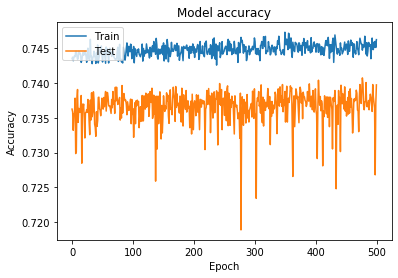

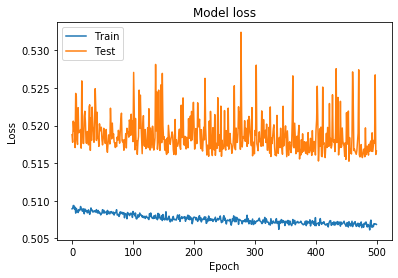

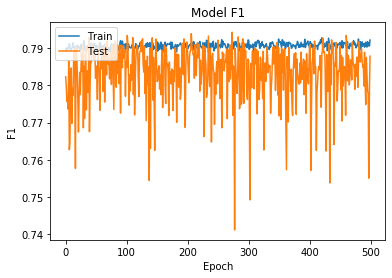

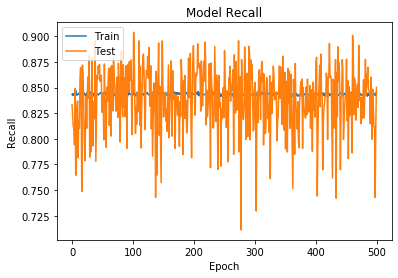

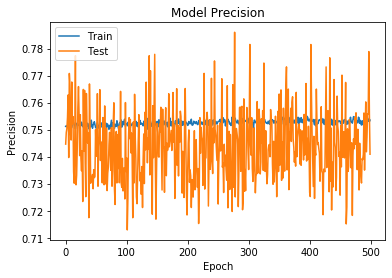

In [81]:
#Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
ax2 = plt.plot(history.history['loss'])
ax2= plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Plot training & validation F-1
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Plot training & validation recall 
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Plot training & validation precision 
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#loss: 0.5179 - accuracy: 0.7380 - f1_m: 0.7853 - precision_m: 0.7447 - recall_m: 0.8422
#data_f = data_train[['goal', 'staff_pick', 'blurb_length', 'period_lc', 'period_dl', 'money_pday', 'name_length', 'competitors_qtr', 'competitors_month', 'category_art', 'category_comics', 'category_crafts', 'category_dance', 'category_design', 'category_fashion', 'category_film & video', 'category_food', 'category_games', 'category_journalism', 'category_music', 'category_photography', 'category_publishing', 'category_technology', 'category_theater', 'funded']]
#loss: 0.5144 - accuracy: 0.7394 - f1_m: 0.7855 - precision_m: 0.7463 - recall_m: 0.8401

#200 epoch: 0.5221889174143474, 0.7361000180244446, 0.7870576977729797, 0.7334079742431641, 0.8584153056144714

Test Data Cleaning and Standardization

In [ ]:
# upper_case
upper_case = []
for i in range(len(data_test)):
    if data_test.iloc[i].blurb != data_test.iloc[i].blurb:
        upper_case.append(0) 
    else:
        value = sum(map(str.isupper, data_test.iloc[i].blurb.split()))
        upper_case.append(value)
data_test['upper_case'] = upper_case

In [ ]:
#count number of sentence signs: cor with funded #0.09027529333321695
count_mark = []
data_test['blurb'] = data_test['blurb'].astype(str)
for i in range(len(data_test)):
    val_1 = data_test.iloc[i].blurb.count('!')
    val_2 = data_test.iloc[i].blurb.count('?')
    val_3 = data_test.iloc[i].blurb.count('-')
    val_4 = data_test.iloc[i].blurb.count('$')
    val_5 = data_test.iloc[i].blurb.count(',')
    val_6 = data_test.iloc[i].blurb.count('\'')
    val_7 = data_test.iloc[i].blurb.count('"')
    count_mark.append(val_1+val_2+val_3+val_4+val_5+val_6+val_7)
data_test['count_sign'] = count_mark

In [21]:
#standardize: staff_pick
boolean_v = []
for i in range(len(data_test)):
    boolean = data_test.iloc[i].staff_pick
    if boolean == True:
        boolean_v.append(1)
    elif boolean == False:
        boolean_v.append(0)
data_test['staff_pick'] = boolean_v

In [22]:
#period_lc   #period_dl   #money_pday
launched_at = []
created_at = []
deadline = []
for i in range(len(data_test)):
    launched_at.append(datetime.utcfromtimestamp(data_test.iloc[i].launched_at).strftime('%Y-%m-%d'))
    created_at.append(datetime.utcfromtimestamp(data_test.iloc[i].created_at).strftime('%Y-%m-%d'))
    deadline.append(datetime.utcfromtimestamp(data_test.iloc[i].deadline).strftime('%Y-%m-%d'))

date_format = "%Y-%m-%d"
period_lc = []
period_dl = []
money_pday = []
for i in range(len(data_test)):
    l = launched_at[i]
    l = datetime.strptime(l, date_format)
    c = created_at[i]
    c = datetime.strptime(c, date_format)
    d = deadline[i]
    d = datetime.strptime(d, date_format)
    lc = l - c
    period_lc.append(lc.days)
    dl = d - l
    period_dl.append(dl.days)
    money_pday.append(math.ceil(data_test.iloc[i].goal / dl.days)) 
data_test['period_lc'] = period_lc
data_test['period_dl'] = period_dl
data_test['money_pday'] = money_pday

In [23]:
#standardize: name_length
data_test['name_length'] = data_test['name']
name_length = []
for i in range(len(data_test)):
    if data_test.iloc[i].name_length != data_test.iloc[i].name_length:
        name_length.append(0)
    else:
        name_length.append(len(data_test.iloc[i].name_length)) 
data_test['name_length'] = name_length

In [24]:
#standardize: goal
goal_usd = []
for i in range(len(data_test)):
    value = math.ceil(data_test.iloc[i].fx_rate * data_test.iloc[i].goal)
    goal_usd.append(value)
data_test['goal'] = goal_usd

In [25]:
#standardize: blurb_length
data_test['blurb'].astype(str)
blurb_length = []
for i in range(len(data_test)):
    if data_test.iloc[i].blurb != data_test.iloc[i].blurb:
        blurb_length.append(0)
    else:
        blurb_length.append(len(data_test.iloc[i].blurb))  
data_test['blurb_length'] = blurb_length

In [26]:
data_test['launched_month'] = data_test['launched_at'].apply(get_month)
data_test['launched_week'] = data_test['launched_at'].apply(get_week)
data_test['launched_quarter'] = data_test['launched_at'].apply(get_quarter)
data_test['launched_year'] = data_test['launched_at'].apply(get_year)
data_test['goal_cat_perc'] =  data_test.groupby(['category'])['goal'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =[1,2,3]))
data_test['duration_cat_perc'] =  data_test.groupby(['category'])['period_dl'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =False, duplicates='drop'))

In [27]:
data_test['competitors_qtr'] = data_test.groupby(['category','launched_year','launched_quarter','goal_cat_perc'])['name'].transform('count')
data_test['competitors_month'] = data_test.groupby(['category','launched_year','launched_month','goal_cat_perc'])['name'].transform('count')

In [28]:
data_test = pd.get_dummies(data_test, columns = ['category'])

Test dataset prediction

In [30]:
data_f = data_test[['goal','staff_pick', 'blurb_length', 'period_lc', 'period_dl', 'money_pday', 'name_length', 'competitors_qtr', 'competitors_month', 'category_art', 'category_comics', 'category_crafts', 'category_dance', 'category_design', 'category_fashion', 'category_film & video', 'category_food', 'category_games', 'category_journalism', 'category_music', 'category_photography', 'category_publishing', 'category_technology', 'category_theater', 'upper_case', 'count_sign', 'funded']]

In [31]:
X_t = data_eval.values
scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler.fit(scaler, X_t)
X_test = scaler.transform(X_t)

In [37]:
probabilities = model.predict(X_test)
pred_results = pd.DataFrame(index = data_test.index)
pred_results['prediction'] = probabilities

In [38]:
import csv
label_file = "predictions.tsv"
with open(label_file, 'w') as write_tsv:
    write_tsv.write(pred_results.to_csv(sep='\t', index = True))